# Amdahl's Law Analysis & Amdahl's Law Plus

- **Author**: Yintao, Xu
- **Date**: 2021/11/21

This notebook discusses the Amdahl's law and proposes Amdah's Law+ to fit that formula into real-world prediction, considering overhead of sychronization and creation of threads.

In [159]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as Ftorch

import torch.optim as optim

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal', 
        'size'   : 18}

matplotlib.rc('font', **font)

## Amdahl's Law

>In computer architecture, Amdahl's law (or Amdahl's argument) is a formula which gives the theoretical speedup in latency of the execution of a task at fixed workload that can be expected of a system whose resources are improved. It is named after computer scientist Gene Amdahl, and was presented at the AFIPS Spring Joint Computer Conference in 1967.

$$
    S(p; F) = \frac{1}{F + (1 - F) / p}
$$
where $p\in \mathbb{Z^+}$ is number of process, $F \in (0, 1)$ is fraction of sequential part of program.

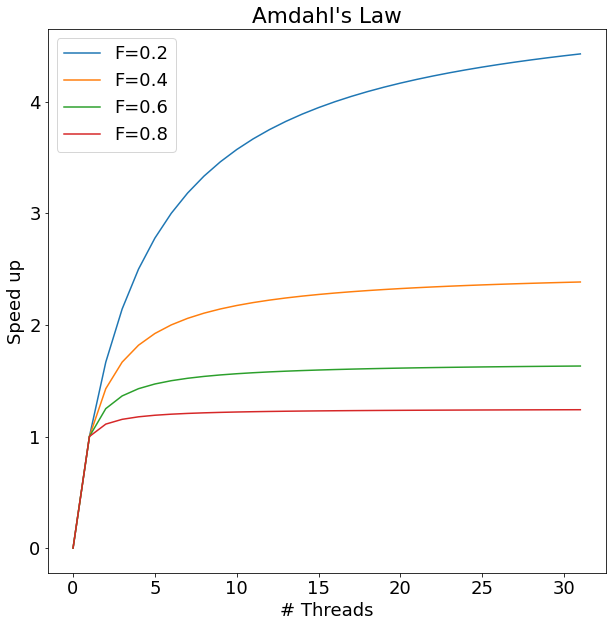

In [160]:
def amdahl(F, p):
    return 1 / (F + (1 - F) * (1 / p))

plt.rcParams['figure.figsize'] = [10, 10]

p = torch.from_numpy(np.array([_ for _ in range(32)]))
Fs = [0.2, 0.4, 0.6, 0.8]

for F in Fs:
    y = amdahl(F, p)
    plt.plot(p, y, label='F={}'.format(F))

plt.title("Amdahl's Law")
plt.xlabel("# Threads")
plt.ylabel("Speed up")
plt.legend()
plt.show()

## Overhead of threads: a glimpse of PARSEC 3.0

**Observation**: Theortically, there is a diminishing return. When `#threads` goes to infinity, the speed-up approximates `1/ F`.

However, in real-world scenerio, the overhead of multithreading pays an important role when `#threads` go to large.

torch.Size([33, 8]) torch.Size([33, 4])


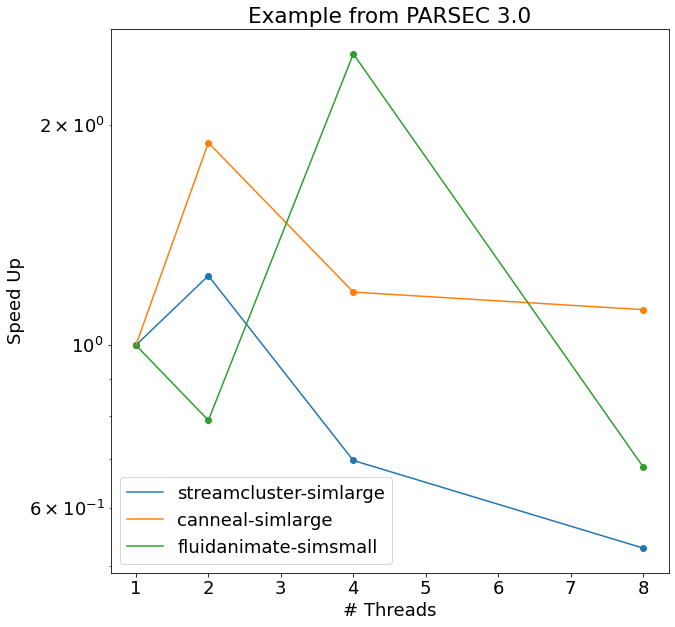

In [161]:
# load the data
csv_path = os.path.join("data", "dataset.csv")
df = pd.read_csv(csv_path)
dfname = df[['Name', 'Size']]

# pick columns of interest
Xdf = df[['total-instructions', 'L3-cache-misses', 'L1-data-cache-loads', 'branch-misses in %', 'L3-cache-references', 'Threads', 'IPC', 'branch-misses in %']]
ydf = df[['Speedup']]
Xlegend = dfname.to_numpy()[::4]

# convert to torch tensor to visualize
X = torch.from_numpy(Xdf.to_numpy())
y = torch.from_numpy(ydf.to_numpy())

X_enc = []
y_enc = []

for i in range(0, X.shape[0], 4):
    x_spl = X[i]
    y_spl = y[i: i + 4].view(4)
    
    X_enc.append(x_spl.numpy())
    y_enc.append(y_spl.numpy())
    
X = torch.from_numpy(np.array(X_enc))
y = torch.from_numpy(np.array(y_enc))

print(X.size(), y.size())

# plot the figure
ts = [1, 2, 4, 8]
idxs = [2, 11, 18]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for idx in idxs:
    ax.plot(ts, y[idx], label=Xlegend[idx, 0] + '-' + Xlegend[idx, 1])
    ax.scatter(ts, y[idx])

plt.rcParams['figure.figsize'] = [15, 8]
plt.title("Example from PARSEC 3.0")
ax.set_yscale('log')
plt.ylabel("Speed Up")
plt.xlabel("# Threads")
plt.legend()

**Insight**: There is a peek of performance at optimal configuration of `#threads`. It is also a very critical points when programmers deploy programs.

## Amdahl's Plus Formula

We introduce an extra term $o = (p - 1) \cdot \lambda \cdot T_{seq}$ at denominator to approximate overhead cost introduced by more threads, basing on assumptions:

- $o \propto p$, cost of overhead increases when we introduce more threads.
- $o \propto T_{seq}$ more lengthy program requires more synchronization cost.

$$
    S(p; F, \lambda) = \frac{1}{F + (1 - F) / p + (p - 1) \cdot \lambda}
$$
where:
- $p\in \mathbb{Z^+}$ is number of process
- $F \in (0, 1)$ is fraction of sequential part of program
- $\lambda \in (0, +\infty)$ is coffcient to estimate overhead.

Try to solve the optimal solution for p

$$
    \frac{\partial S(p; F, \lambda)}{\partial p}= (-S^2)((F - 1) \cdot \frac{1}{p^2} + \lambda)
$$
optimal point $p^*$ should follows $\partial S / \partial p = 0$:
$$
    p^* = \sqrt{\frac{1-F}{\lambda}}
$$

### Corner cases sanity check

1. When $F \to 1$, which means there is no parallel section, $p^* \to 0$, the formula is consistent with intuition.
2. When $\lambda \to \infty$, which means the overhead of more threads is intractable, $p^* \to 0$ shows that we should not introduce parallelism.

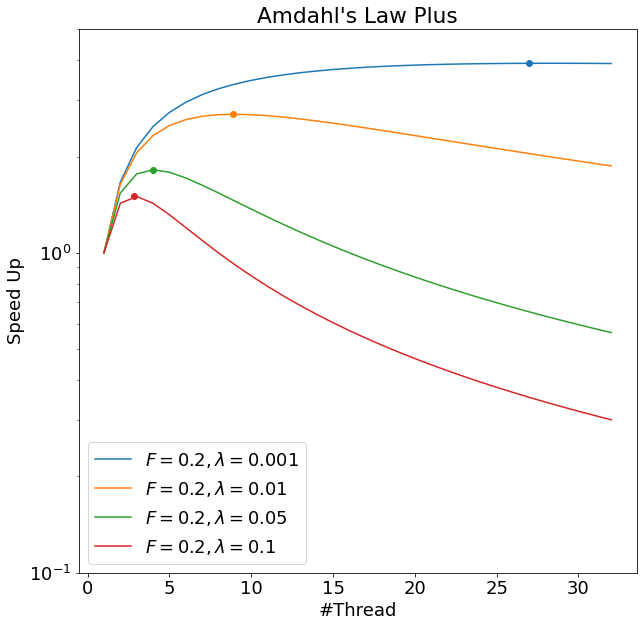

In [166]:
def amdahl_plus(F, lmd, p):
    return 1 / (F + (1 - F) * (1 / p) + (p - 1) * lmd)

def opt_p(F, lmd):
    ret = np.sqrt((1 - F) / (lmd + 1e-4))
    return np.clip(ret, a_min=1.0, a_max=32)

p = torch.from_numpy(np.array([_ for _ in range(1, 33)]))
lmds = [0.001, 0.01, 0.05, 0.1]

plt.rcParams['figure.figsize'] = [10, 10]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for lmd in lmds:
    out = amdahl_plus(F=0.2, lmd=lmd, p=p)
    
    ax.plot(p, out, label='$F=0.2, \lambda={}$'.format(lmd))
    p_ = opt_p(F=0.2, lmd=lmd)
    plt.scatter([p_], [amdahl_plus(F=0.2, lmd=lmd, p=p_)])

plt.title("Amdahl's Law Plus")
plt.ylabel("Speed Up")
plt.xlabel("#Thread")
ax.set_yscale('log')
ax.set_ybound(0.1, 5)
plt.legend()
plt.show()

### Visuals

Here two figures visualizes how speed up changes with respect to $F$ and $\lambda$.

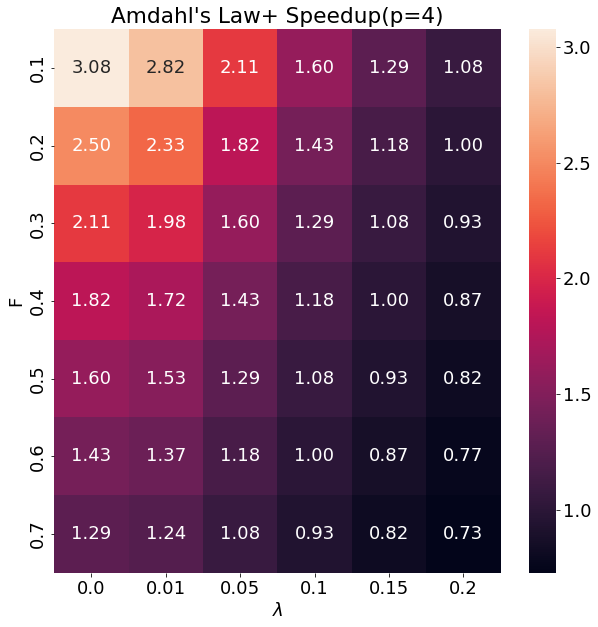

In [167]:
F = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
L = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2]

out_f = []
out_l = []
out = []

df_data = []

for f in F:
    for l in L:
        df_data.append([f, l, amdahl_plus(F=f, lmd=l, p=4)])
df = pd.DataFrame(data=df_data, columns=['F', '$\lambda$', 'SpeedUp'])
    
vis = df.pivot('F', '$\lambda$', 'SpeedUp')
plt.title("Amdahl's Law+ Speedup(p=4)")
ax = sns.heatmap(vis, annot=True, fmt=".2f")

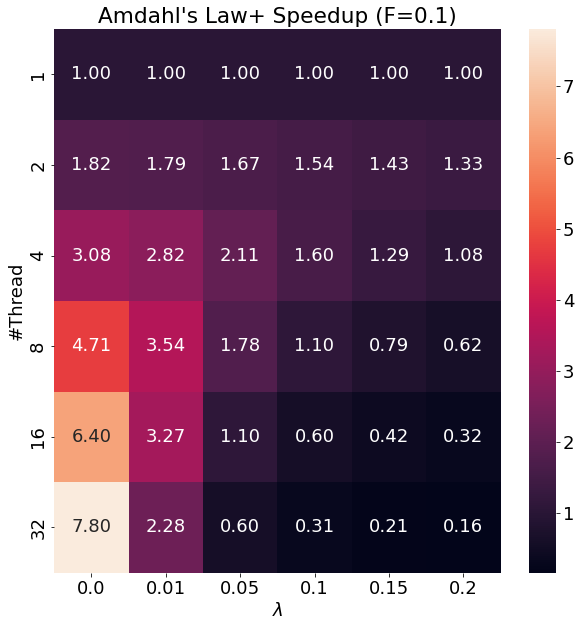

In [168]:
L = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2]
P = [1, 2, 4, 8, 16, 32]

out_f = []
out_l = []
out = []

df_data = []

for l in L:
    for p in P:
        df_data.append([l, p, amdahl_plus(F=0.1, lmd=l, p=p)])
df = pd.DataFrame(data=df_data, columns=['$\lambda$', '#Thread', 'SpeedUp'])
    
vis = df.pivot('#Thread', '$\lambda$', 'SpeedUp')
plt.title("Amdahl's Law+ Speedup (F=0.1)")
ax = sns.heatmap(vis, annot=True, fmt=".2f")

### Amdahls+ directly fits to current curve

One experiment could be: given thread-speedup curve for a specific task, could we regress `(F, lmd)`? Would gradient descent converges?

- The composition of two convex functions is a convex function.
- Gradient descent algorithm would converge over a convex loss function.
- The $1/s(p;f, \lambda)$ is a convex function. L1-Loss is a convex function.
    - Therefore, L1-loss with respect to inverse estimated speedup is convex.
- Therefore, instead of fitting $s(p;f, \lambda)$ to $s_{gt}$. We fit $1 / s(p;f, \lambda)$ for the sake of convergence, also for numerical stability.

F=0.28, lambda=1.8828


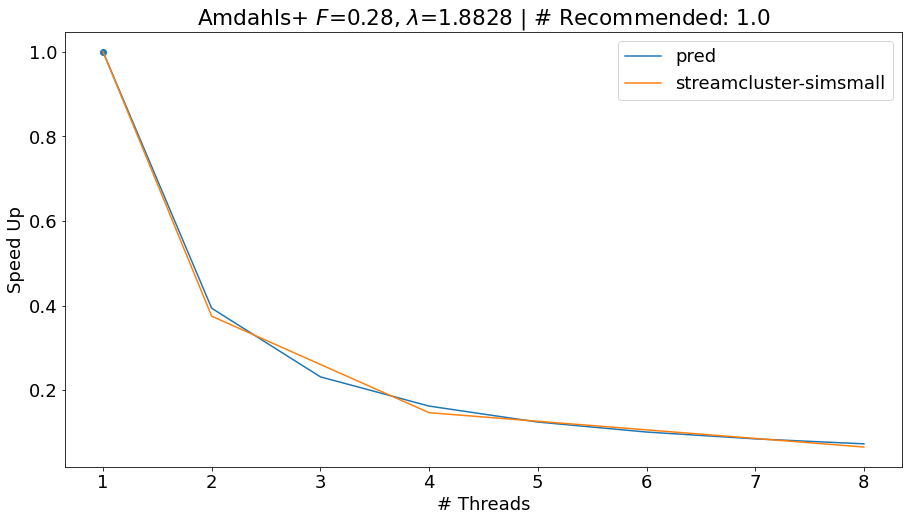

F=0.14, lambda=0.6516


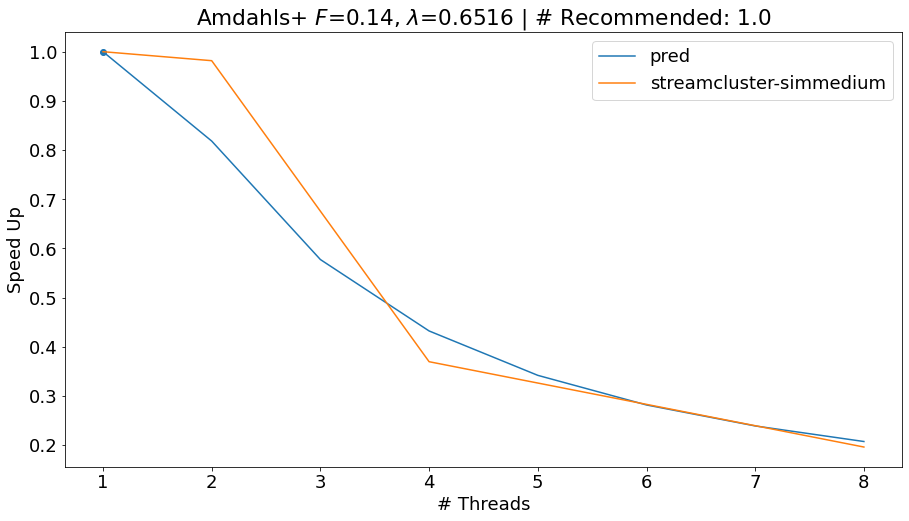

F=0.53, lambda=0.1917


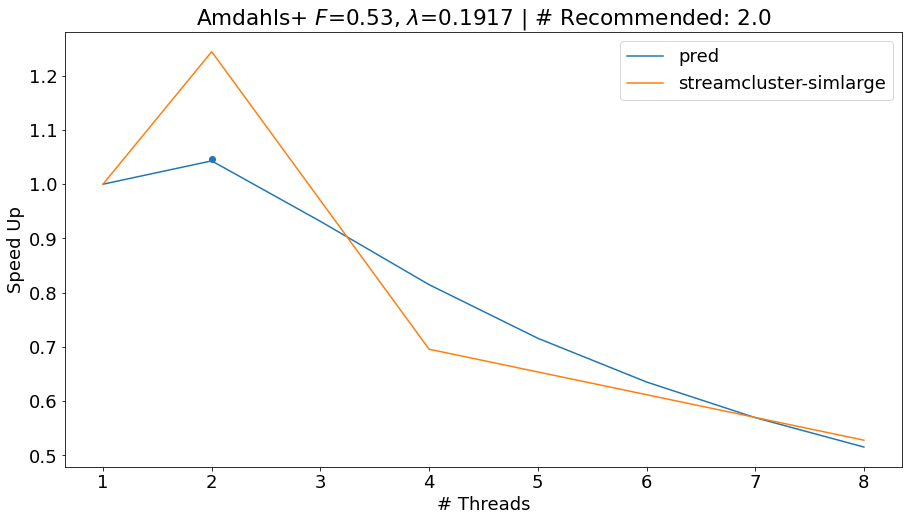

F=0.90, lambda=0.0204


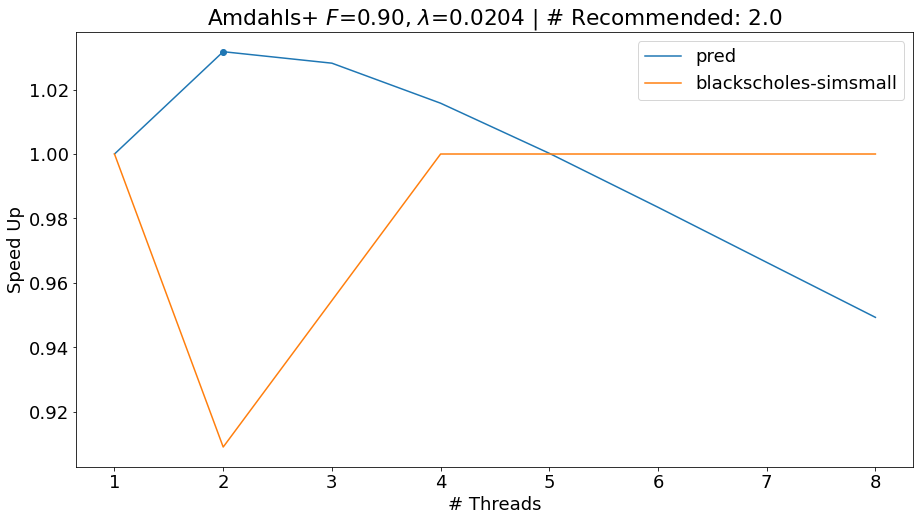

F=0.10, lambda=0.0801


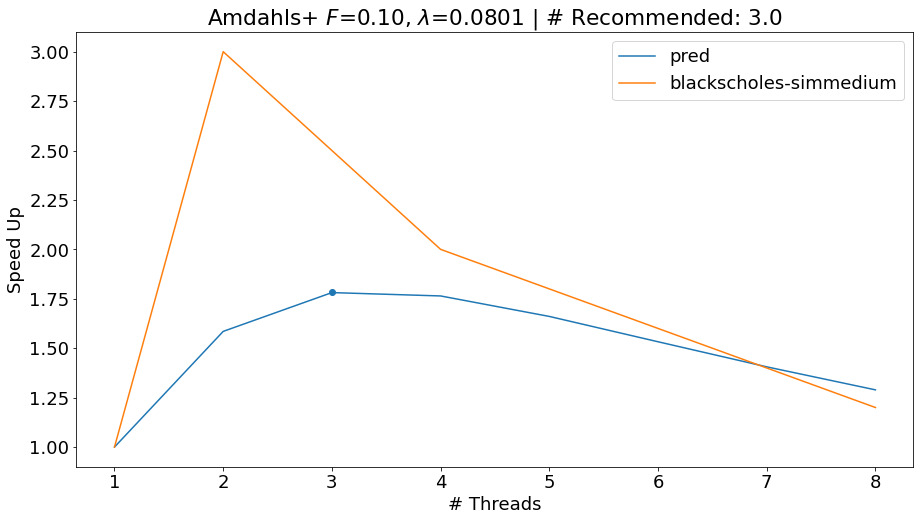

F=0.10, lambda=0.0341


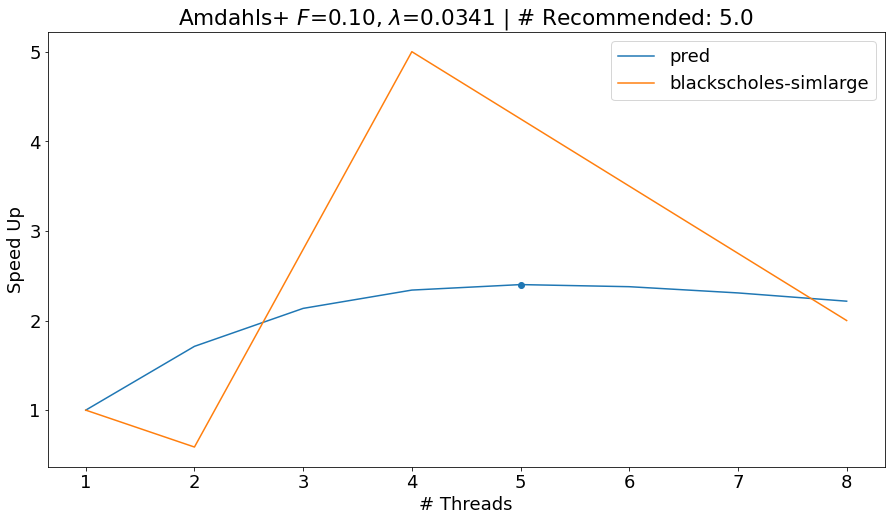

F=0.10, lambda=0.0308


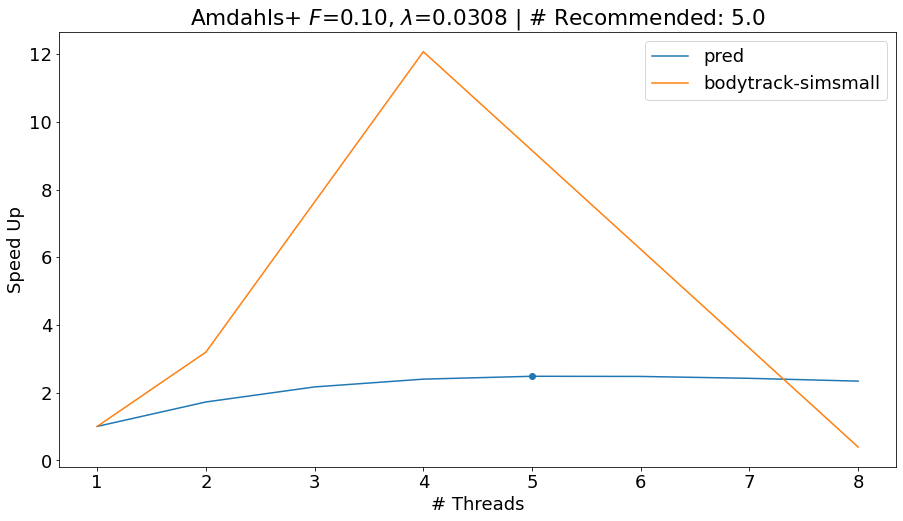

F=0.90, lambda=0.2957


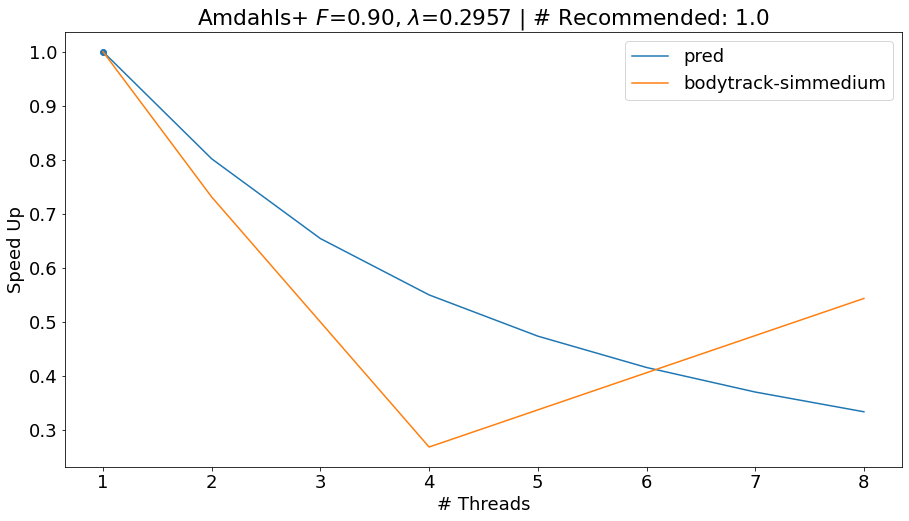

F=0.10, lambda=0.0138


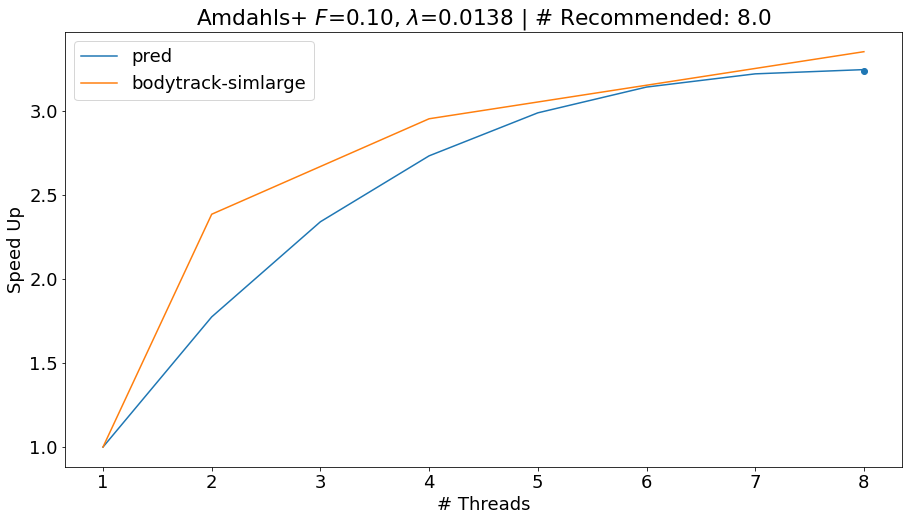

F=0.12, lambda=0.0739


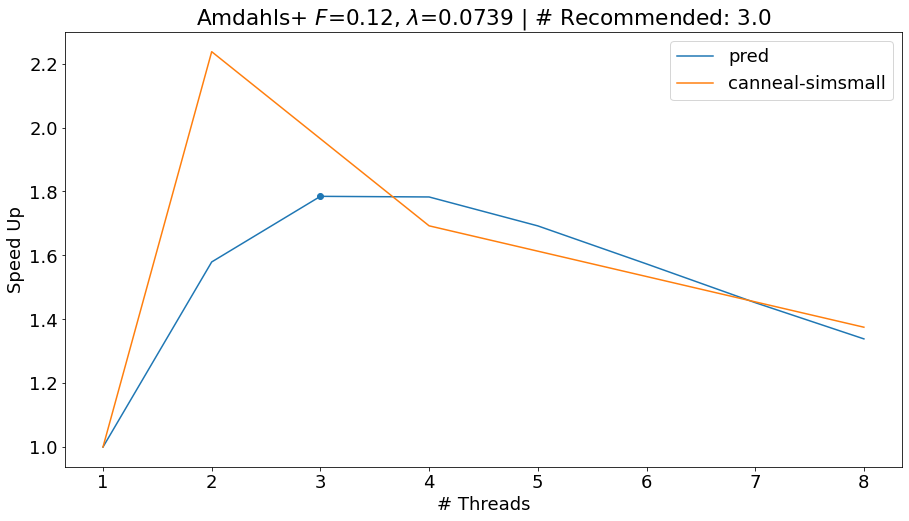

F=0.16, lambda=0.0689


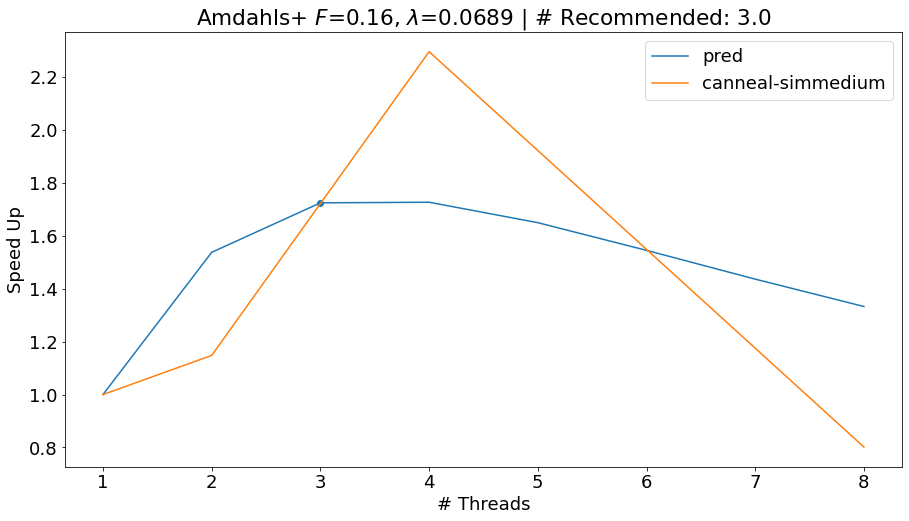

F=0.34, lambda=0.0773


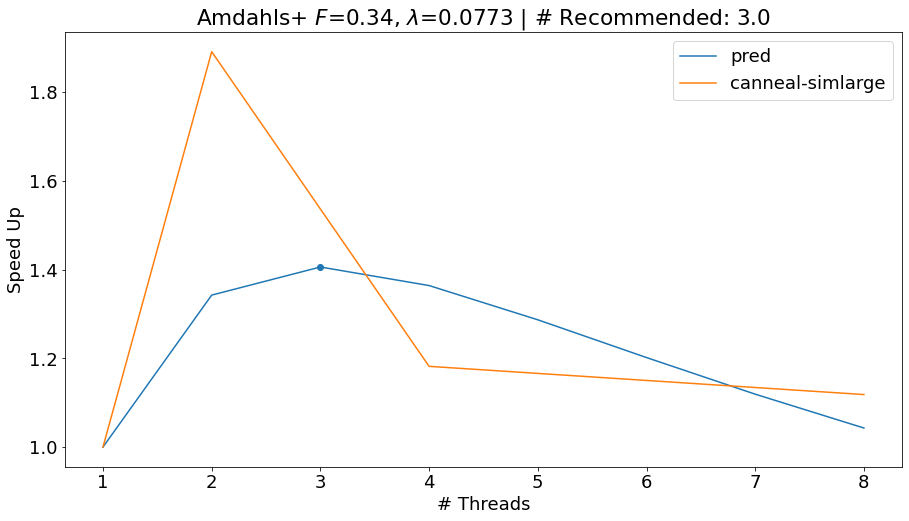

F=0.88, lambda=0.1187


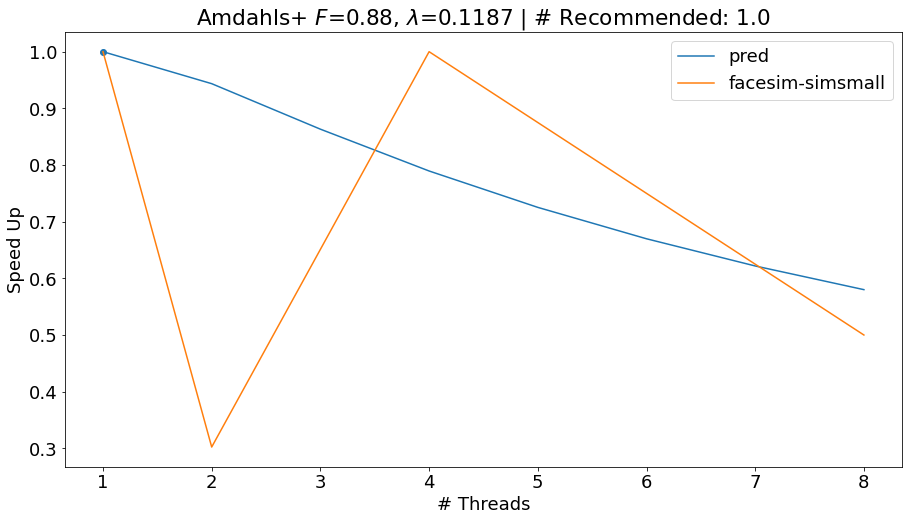

F=0.29, lambda=0.1477


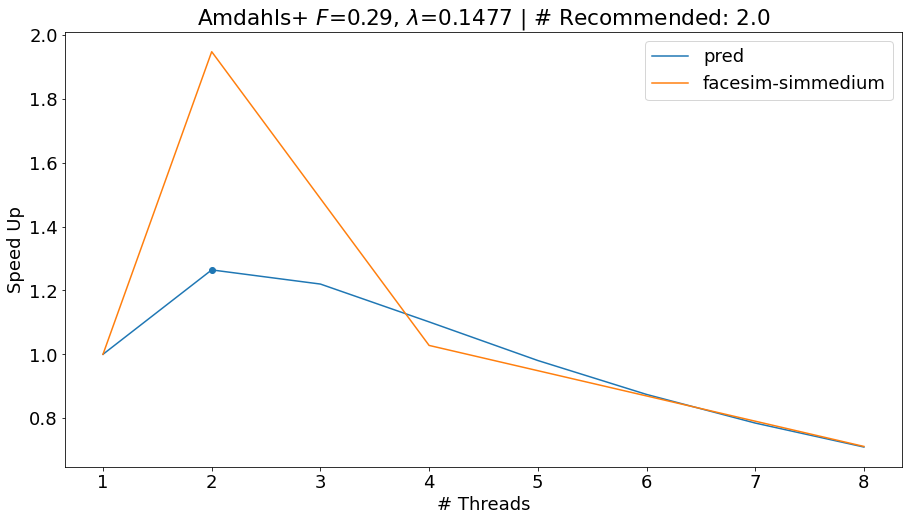

F=0.65, lambda=0.0215


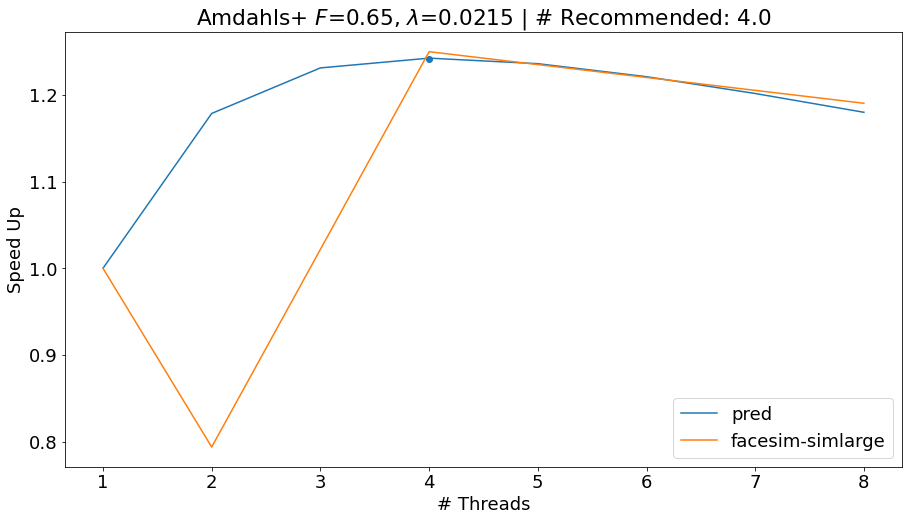

F=0.10, lambda=0.0193


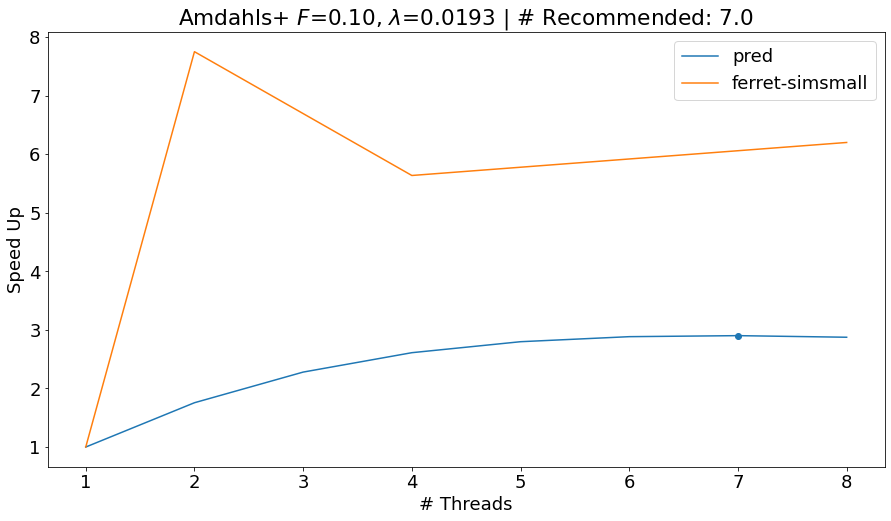

F=0.90, lambda=0.0640


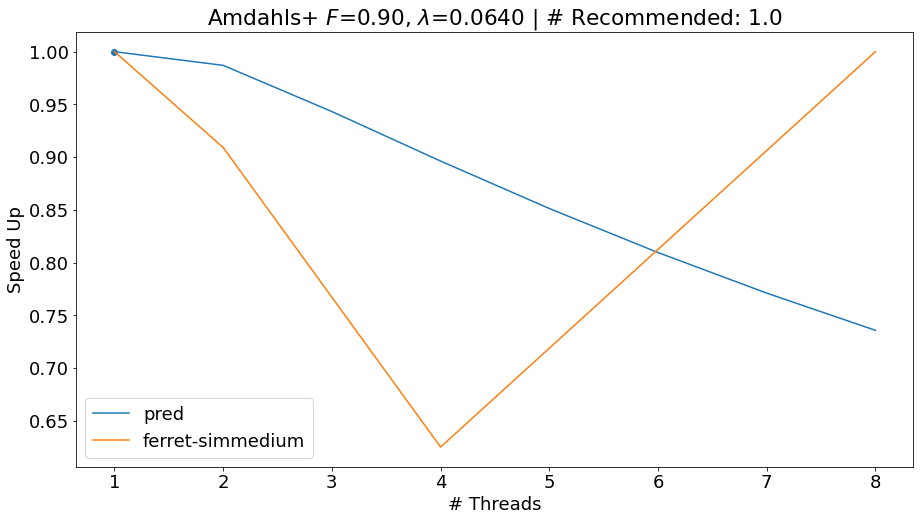

F=0.13, lambda=0.0772


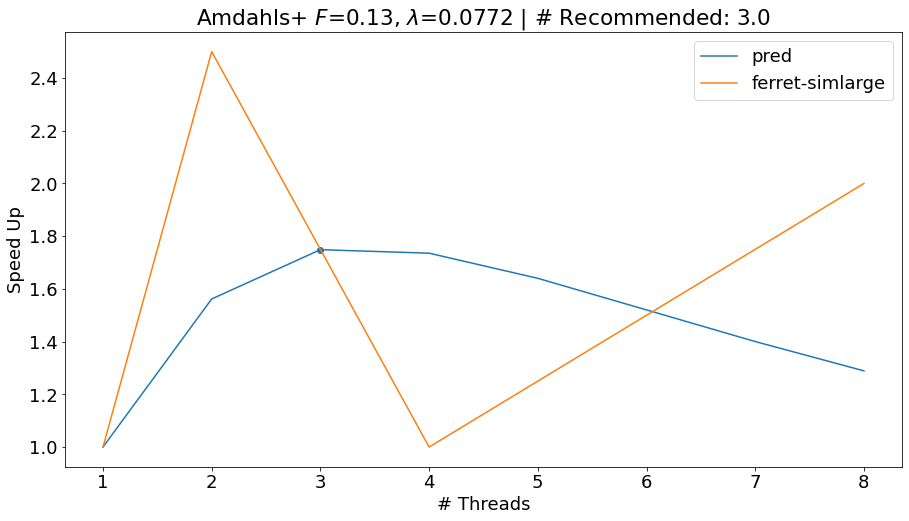

F=0.27, lambda=0.0472


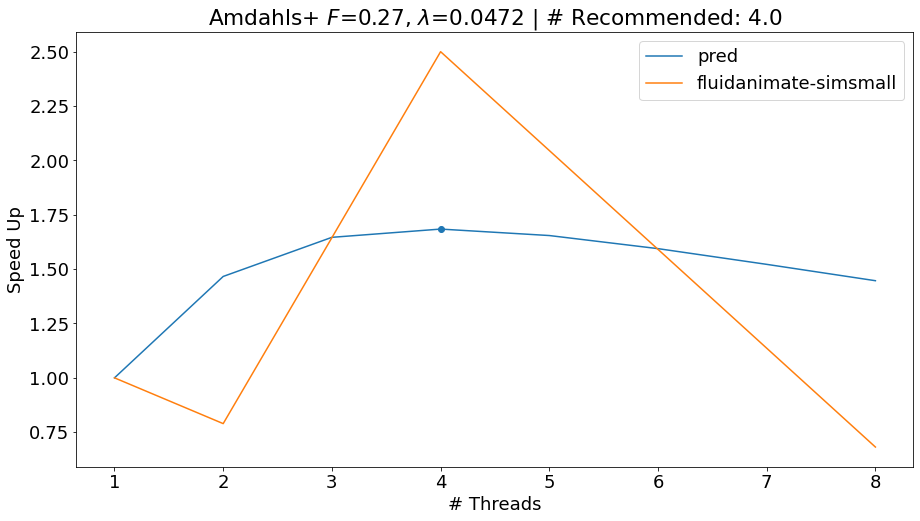

F=0.18, lambda=0.1497


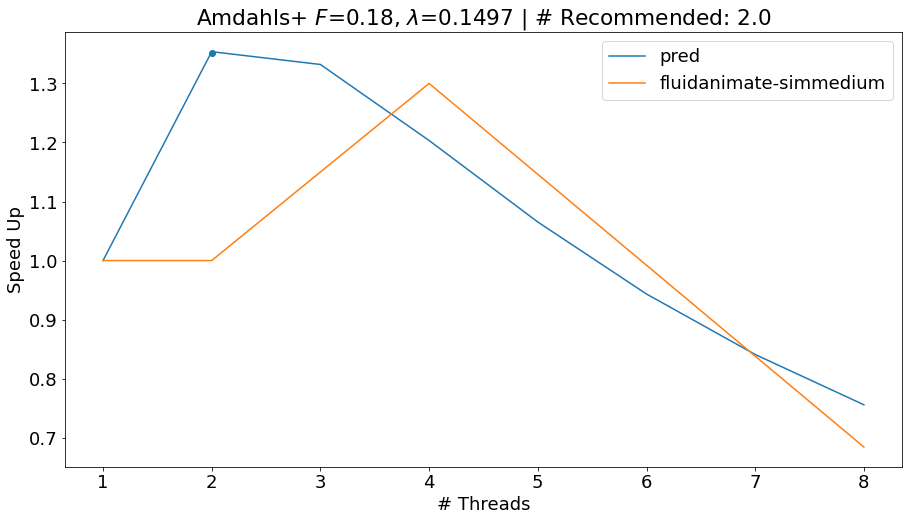

F=0.65, lambda=0.0867


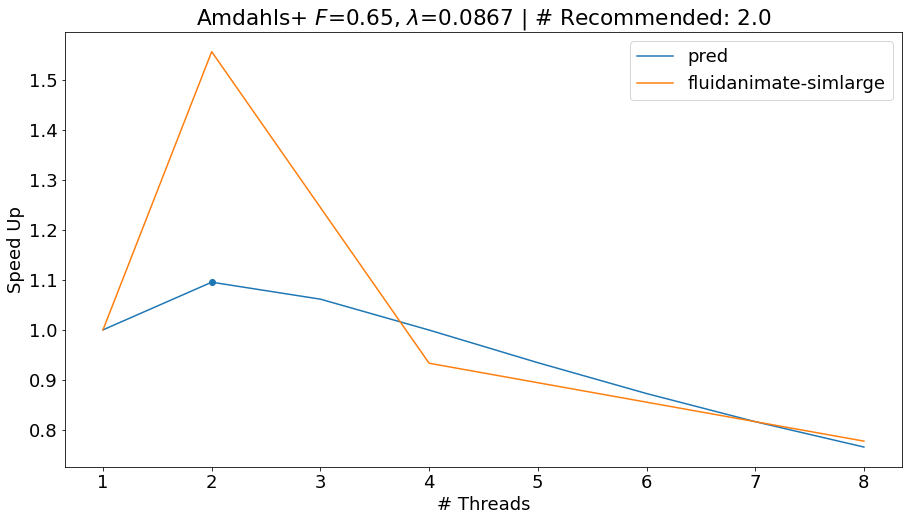

F=0.90, lambda=0.1049


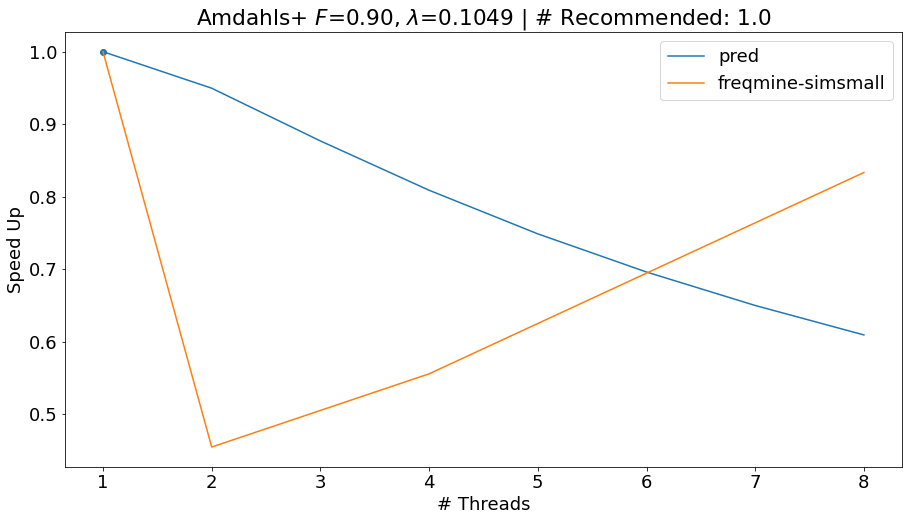

F=0.82, lambda=0.2662


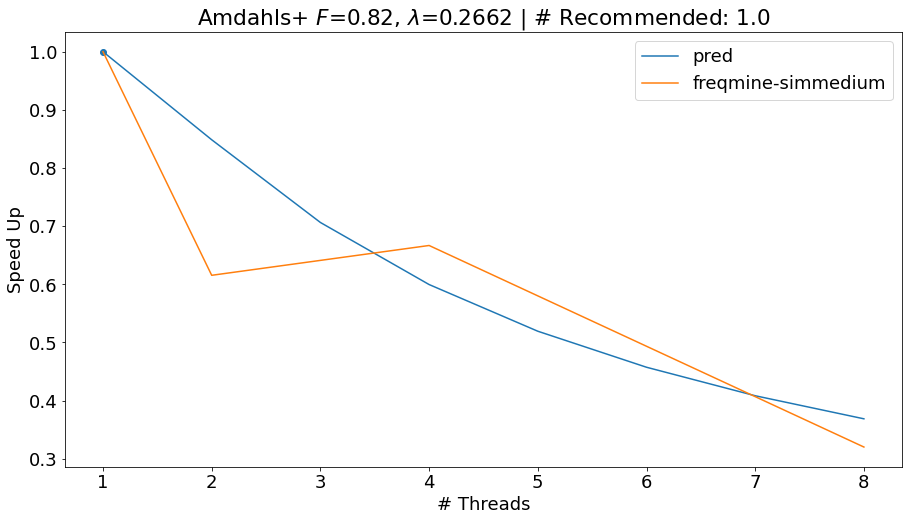

F=0.10, lambda=0.0308


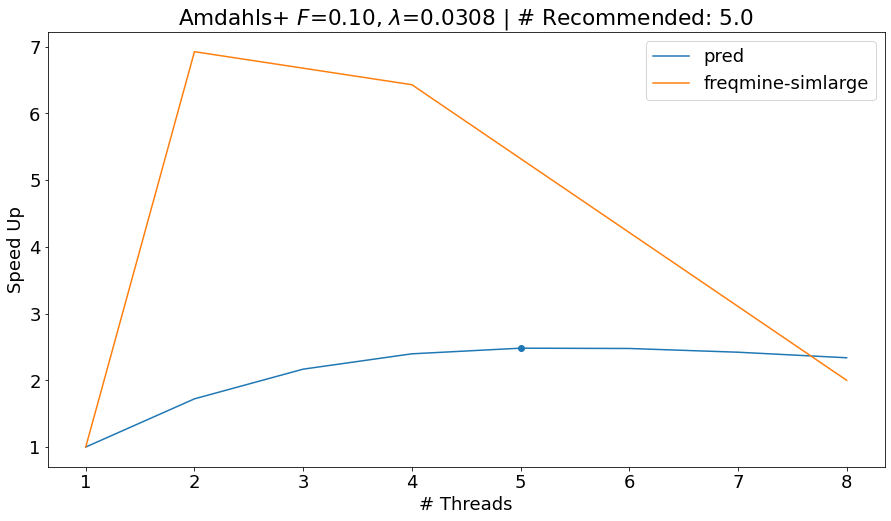

F=0.30, lambda=0.0109


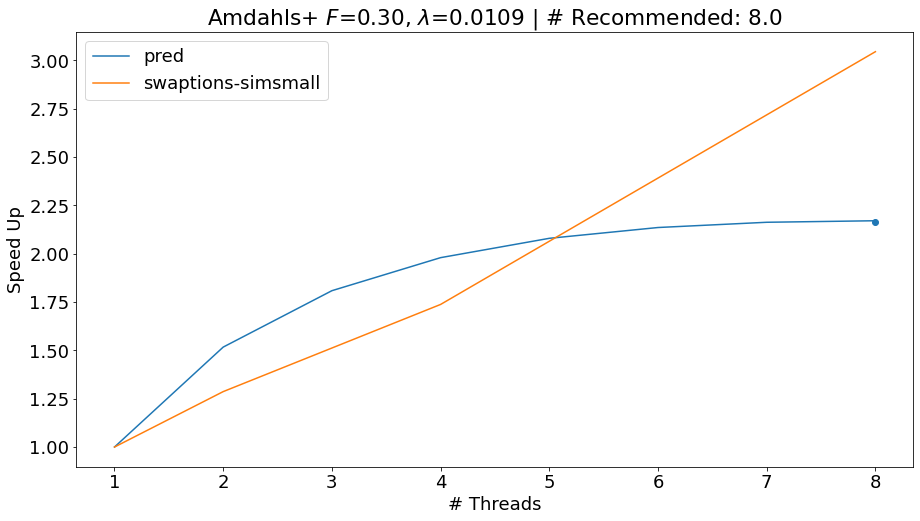

F=0.10, lambda=0.0136


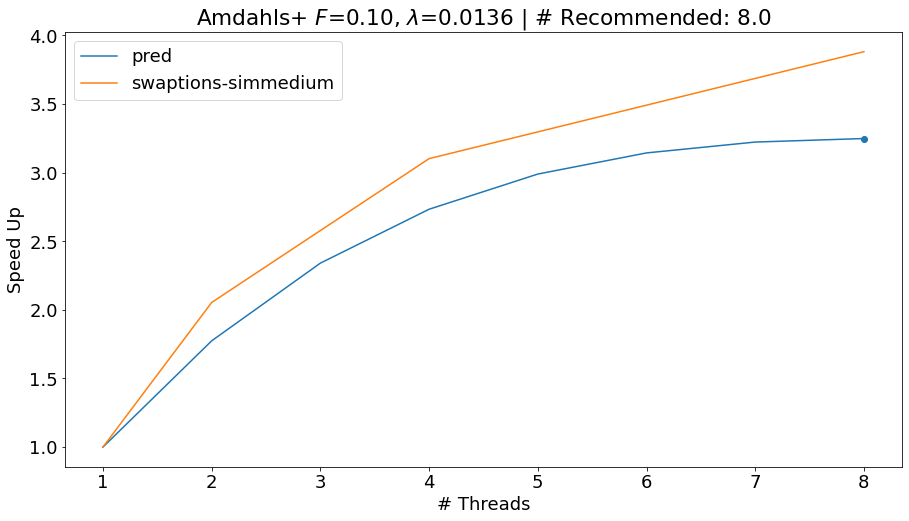

F=0.10, lambda=0.0138


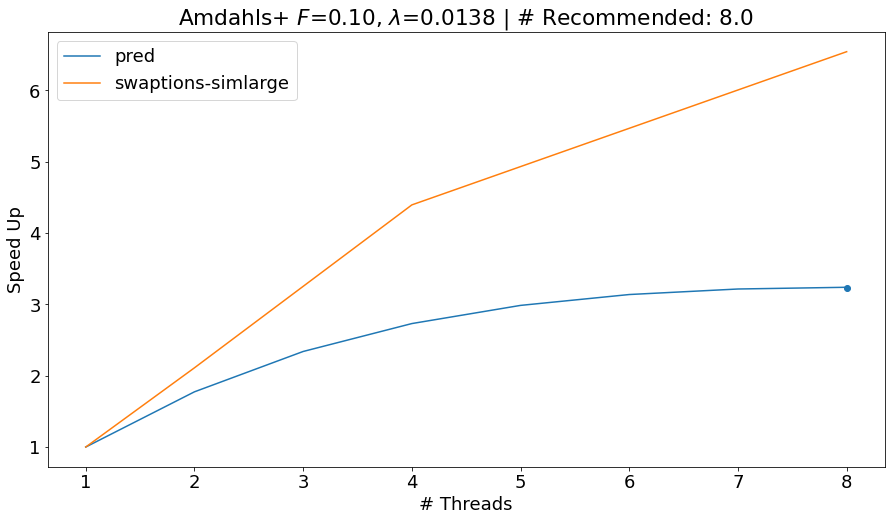

F=0.10, lambda=0.0193


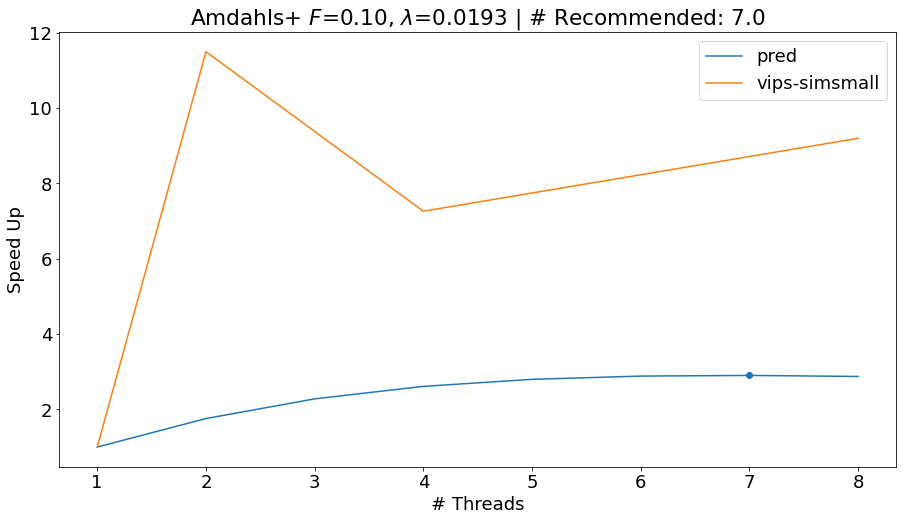

F=0.90, lambda=0.0669


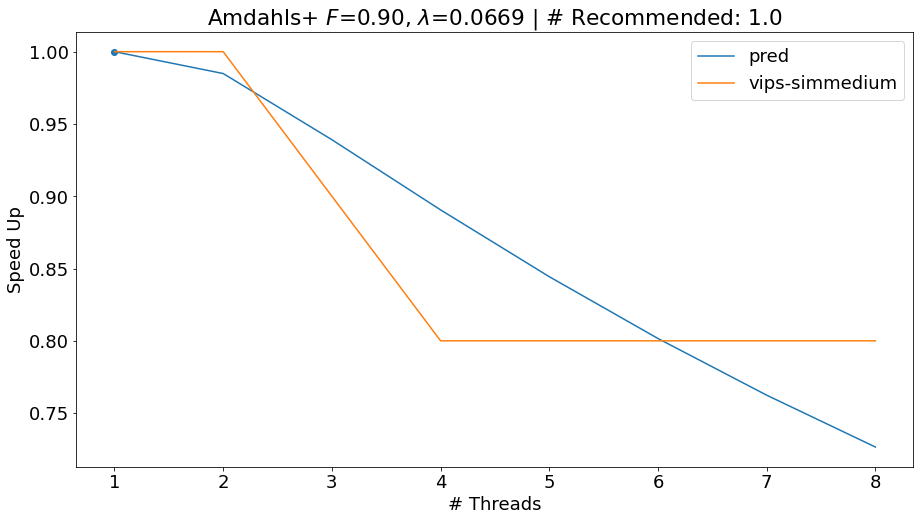

F=0.59, lambda=0.0510


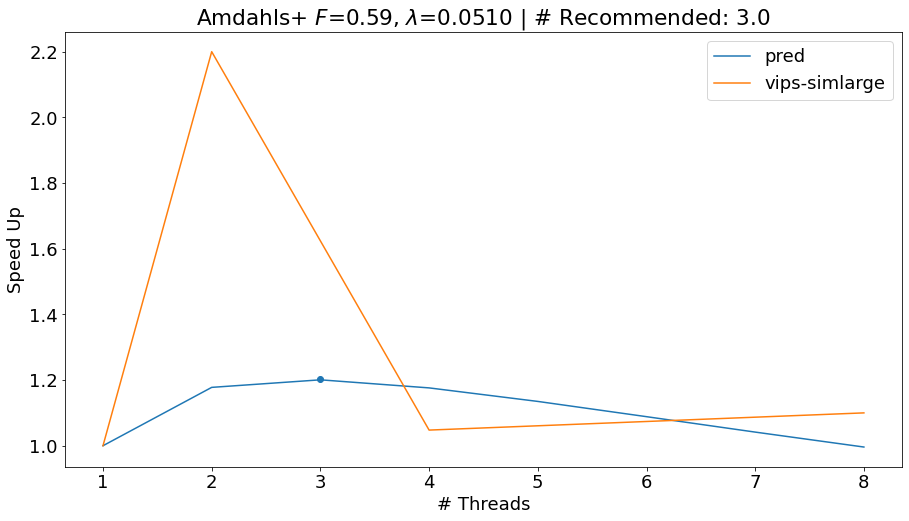

F=0.37, lambda=0.0098


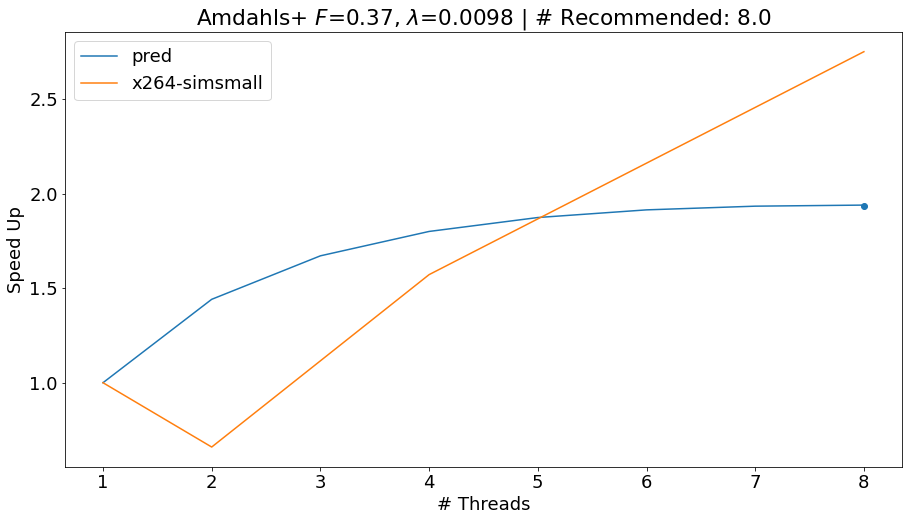

F=0.90, lambda=0.2716


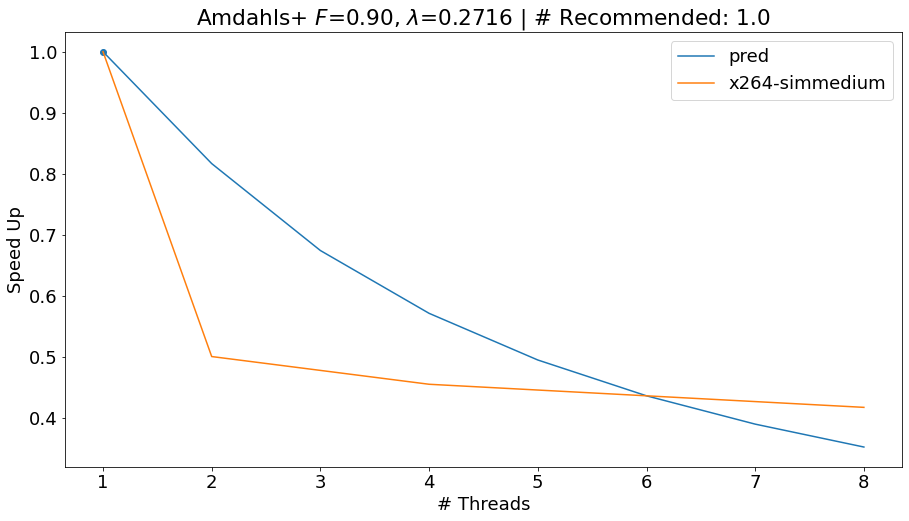

F=0.90, lambda=0.4435


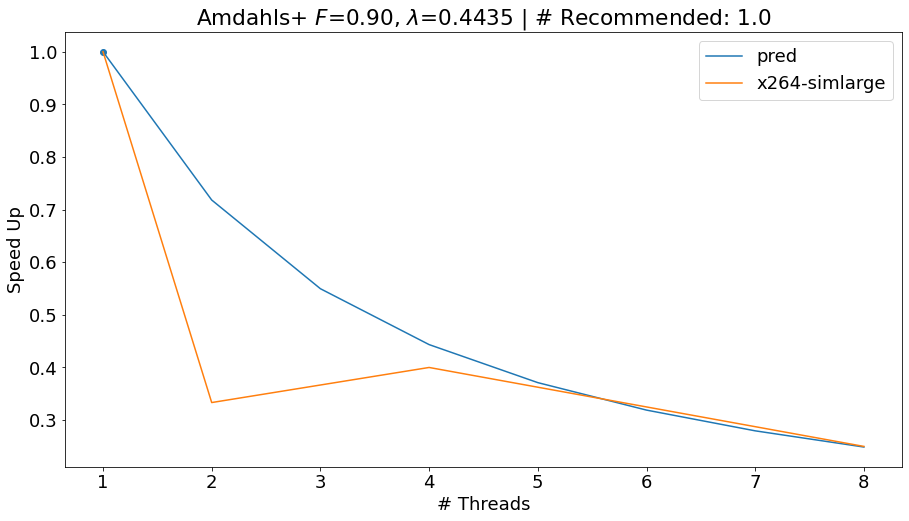

In [285]:
def amdahl_plus_inv(F, lmd, p):
    # 1e-6 for numerical stability
    return F + (1 - F) * (1 / (p + 1e-6)) + (p - 1) * lmd

def opt_p(F, lmd):
    ret = np.sqrt((1 - F) / (lmd + 1e-4))
    return np.clip(ret, a_min=1.0, a_max=8)

class Amdahl_Plus(nn.Module):
    def __init__(self):
        super().__init__()
        self.F_lmd = nn.Parameter(torch.randn(2,))
        self.F_lmd.data[0] = -10
        self.F_lmd.data[1] = -10

    def forward(self, p):
        F = torch.sigmoid(self.F_lmd[0]) * 0.8 + 0.1
        lmd = torch.exp(self.F_lmd[1])
        
        opt_p = torch.sqrt((1 - F)/ (lmd + 1e-4))

        return amdahl_plus_inv(F, lmd, p), opt_p
    
    def print_args(self):
        F = float((torch.sigmoid(self.F_lmd[0]) * 0.8 + 0.1).detach().numpy())
        lmd = float(torch.exp(self.F_lmd[1]).detach().numpy())
        print("F={:.2f}, lambda={:.4f}".format(F, lmd))
        return F, lmd

for idx in range(33):
    # sample one example
    y_spl = y[idx]
    ts = torch.from_numpy(np.array([1, 2, 4, 8])).float()

    # interplotation
    y_spl_ = []
    ts_ = []
    i = 0
    for t in range(1, 9):
        if i + 1 < ts.size()[0] and ts[i + 1] + 1e-3 < t:
            i += 1
        a = (t - ts[i]) / (ts[i + 1] - ts[i])
        y_spl_.append((1 - a) * y_spl[i] + a * y_spl[i + 1])
        ts_.append(t)


    y_spl = torch.from_numpy(np.array(y_spl_)).float()
    ts= torch.from_numpy(np.array(ts_)).float()

    ap = Amdahl_Plus()
    criterion = nn.L1Loss()
    optimizer = optim.Adam(ap.parameters(), lr=0.08, betas=(0.9, 0.999))

    for epoch in range(750):  # loop over the dataset multiple times
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, opt_t_est = ap(ts)
        opt_t = ts[torch.argmax(y_spl)]
        loss = criterion(outputs, 1.0 / y_spl) + torch.abs(opt_t - opt_t_est) * 0.02 # log for numerical stability
        loss.backward()
        optimizer.step()

        if epoch % 25 == 24:
            loss_test = criterion(1.0 / outputs, y_spl)
#             print('[%d] loss_train: %.3f loss_test: %.3f' %
#                   (epoch + 1, loss, loss_test))

#     print('Finished Training')

    F, lmd = ap.print_args()
    topt = np.round(opt_p(F, lmd))

    plt.rcParams['figure.figsize'] = [15, 8]
    plt.plot(ts, 1.0 / outputs.detach(), label="pred")
    plt.plot(ts, y_spl, label=Xlegend[idx][0] + "-" + Xlegend[idx][1])
    plt.title("Amdahls+ $F$={:.2f}, $\lambda$={:.4f} | # Recommended: {}".format(F, lmd, np.round(topt)))
    plt.scatter([topt], [1.0 / amdahl_plus_inv(F, lmd, topt)])
    ax.set_yscale('log')
    plt.ylabel("Speed Up")
    plt.xlabel("# Threads")
    plt.legend()
    plt.show()